<a href="https://colab.research.google.com/github/Daviunb6202/Projetos-CIS-UnB/blob/main/CIS_Projeto_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise:

## O que foi feito:

Os arquivos de imagens foram organizados em pastas de treino, validação e teste por meio do gerador ImageDataGenerator, utilizando do método flow_from_directory() e outras bibliotecas como glob, os e shutil. As imagens foram divididas em 10 batches, com 500 imagens para treino, 100 para validação e 50 para teste, ou seja, não foi sua capacidade máxima. Além disso, todas passaram por um pré-processamento, que transforma a coloração de RGB para GBR, usada no modelo VGGNet16. 

A minha proposta foi utilizar um modelo sequencial CNN mais simples para uma primeira avaliação, e após, utilizar o mesmo modelo com uma nova ativação elu, métodos de regularização(L2), normalização e otimização(Nadam). 

Vale ressaltar que tentei utilizar de diversos Learning Rates Schedulers, mas sem muito sucesso em seu funcionamento. Quando utilizados, havia uma variação de perda ao redor de um certo valor ao longo das vinte épocas, ao invés de diminuir linearmente.

Para fim de conparação, importei também um modelo VGGnet16, via transfer learning, com apenas a camada de output modificada, com um pooling extra no final.

Por fim, os resultados do modelo CNN melhorado e do VGGNet16 adaptado foram comparados por matriz de confusão e relatório de acurácia, precisão e recall.

-----------------------------------------------------

## Resultados:

Vemos que o modelo mais simples teve um bom resultado no treino, mas não na validação, configurando assim, um caso de 'overfitting'. Após usar o método de regularização l2(suaviação da atualização dos pesos), somados às outras funcionalidades já mencionadas, o resultado no pacote de validação foi melhor. 

Já o modelo VGGNet16 adaptado performou muito bem, como já esperava de um modelo feito para executar uma tarefa tão parecida, bastando reduzir o número de classes para se trabalhar.Vale mencionar que rodei um modelo Xception e os resultados foram bastante fracos, com 50% de acurácia no treino e validação('underfitting'?), o que me impressionou, apesar de não saber dizer o porquê.  

In [1]:
 from google.colab import drive

In [2]:
!pip install tensorflow

     |████████████████████████████████| 462 kB 4.4 MB/s 


In [3]:
!cp '/content/drive/MyDrive/animals.zip' new

In [4]:
!unzip new

Archive:  new
   creating: animals/
   creating: animals/cats/
  inflating: animals/cats/cats_00001.jpg  
  inflating: animals/cats/cats_00002.jpg  
  inflating: animals/cats/cats_00003.jpg  
  inflating: animals/cats/cats_00004.jpg  
  inflating: animals/cats/cats_00005.jpg  
  inflating: animals/cats/cats_00006.jpg  
  inflating: animals/cats/cats_00007.jpg  
  inflating: animals/cats/cats_00008.jpg  
  inflating: animals/cats/cats_00009.jpg  
  inflating: animals/cats/cats_00010.jpg  
  inflating: animals/cats/cats_00011.jpg  
  inflating: animals/cats/cats_00012.jpg  
  inflating: animals/cats/cats_00013.jpg  
  inflating: animals/cats/cats_00014.jpg  
  inflating: animals/cats/cats_00015.jpg  
  inflating: animals/cats/cats_00016.jpg  
  inflating: animals/cats/cats_00017.jpg  
  inflating: animals/cats/cats_00018.jpg  
  inflating: animals/cats/cats_00019.jpg  
  inflating: animals/cats/cats_00020.jpg  
  inflating: animals/cats/cats_00021.jpg  
  inflating: animals/cats/cats_000

In [5]:
import pathlib
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn as sk 
import tensorflow as tf
from tensorflow import keras
import shutil 
import glob
import random
import warnings 
import itertools 

## Organização dos arquivos

In [6]:
#Conferir numero de imagens
list = os.listdir('/content/animals/cats') 
number_files = len(list)
print(number_files)

1000


In [7]:
#Conferir numero de imagens
list = os.listdir('/content/animals/dogs') 
number_files = len(list)
print(number_files)

1000


In [8]:
#Conferir numero de imagens
list = os.listdir('/content/animals/panda') 
number_files = len(list)
print(number_files)

1000


In [9]:
#move para o diretorio das fotos
os.chdir('/content/animals')

#não tendo uma pasta organizada de treino, agora são criadas - treino validade e teste para cachorro gato panda
if os.path.isdir('train/dog') is False:
  os.makedirs('train/dogs')
  os.makedirs('train/cats')
  os.makedirs('train/panda')
  os.makedirs('valid/dogs')
  os.makedirs('valid/cats')
  os.makedirs('valid/panda')
  os.makedirs('test/dogs')
  os.makedirs('test/cats')
  os.makedirs('test/panda')
   
  #são sorteadas 500 imagens das 100  para o treino, 100, para validade e 50 para o teste
  for c in random.sample(glob.glob('/content/animals/cats/*'), 500):
    shutil.move(c, 'train/cats')
  for c in random.sample(glob.glob('/content/animals/dogs/*'), 500):
    shutil.move(c, 'train/dogs')
  for c in random.sample(glob.glob('/content/animals/panda/*'), 500):
    shutil.move(c, 'train/panda')
  for c in random.sample(glob.glob('/content/animals/cats/*'), 100):
    shutil.move(c, 'valid/cats')
  for c in random.sample(glob.glob('/content/animals/dogs/*'), 100):
    shutil.move(c, 'valid/dogs')
  for c in random.sample(glob.glob('/content/animals/panda/*'), 100):
    shutil.move(c, 'valid/panda')
  for c in random.sample(glob.glob('/content/animals/cats/*'), 50):
    shutil.move(c, 'test/cats')
  for c in random.sample(glob.glob('/content/animals/dogs/*'), 50):
    shutil.move(c, 'test/dogs')
  for c in random.sample(glob.glob('/content/animals/panda/*'), 50):
    shutil.move(c, 'test/panda')

#Volta para o diretorio principal
os.chdir('../../')

In [15]:
#Deletando  com todas as suas fotos dentro para poder refazer o train test split 
if os.path.isdir('train/dog') is True:
  for dirpath, dirnames, filenames in os.walk('/content/animals/test'):
    for c in dirnames:
      c = os.path.join('/content/animals/test', c)
      os.rmdir(c)
  os.rmdir('/content/animals/test')
  for dirpath, dirnames, filenames in os.walk('/content/animals/train'):
    for c in dirnames:
      c = os.path.join('/content/animals/train', c)
      os.rmdir(c)
  os.rmdir('/content/animals/train')
  for dirpath, dirnames, filenames in os.walk('/content/animals/valid'):
    for c in dirnames:
      c = os.path.join('/content/animals/valid', c)
      os.rmdir(c)
  os.rmdir('/content/animals/valid')

In [10]:
train_path = '/content/animals/train'
valid_path = '/content/animals/valid'
test_path = '/content/animals/test'

In [60]:
import tensorflow 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Image data generator vai produzir os batches de imagens(em tensor) e suas labels 

train_batches = ImageDataGenerator(preprocessing_function = tensorflow.keras.applications.vgg16.preprocess_input)  
train_batches = train_batches.flow_from_directory(directory=train_path, target_size=(224,224), classes=['cats', 'dogs', 'panda'], batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function = tensorflow.keras.applications.vgg16.preprocess_input)  
valid_batches = valid_batches.flow_from_directory(directory=valid_path, target_size=(224,224), classes=['cats', 'dogs', 'panda'], batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function = tensorflow.keras.applications.vgg16.preprocess_input)  
test_batches = test_batches.flow_from_directory(directory=test_path, target_size=(224,224), classes=['cats', 'dogs', 'panda'], batch_size=10, shuffle=False)
  

Found 1500 images belonging to 3 classes.
Found 300 images belonging to 3 classes.
Found 150 images belonging to 3 classes.


In [61]:
#assegurar do tamanho de cada batch e número de classes
assert train_batches.n == 1500
assert valid_batches.n == 300
assert test_batches.n == 150
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 3

In [64]:
#Por ImageDataGenerator ser um gerador, cada batch é uma instancia chamada pelo batch 
train, train_lab = next(train_batches)
valid, valid_lab = next(valid_batches)
test, test_lab = next(test_batches)

#cada batch reduzido na forma de imput correta e dividindo por 255 para colocar cada pixel em uma escala de 0 a 1 
train = train 
valid = valid 
test = test 

In [65]:
#Função para plotar imagem
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
      ax.imshow(img)
      ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

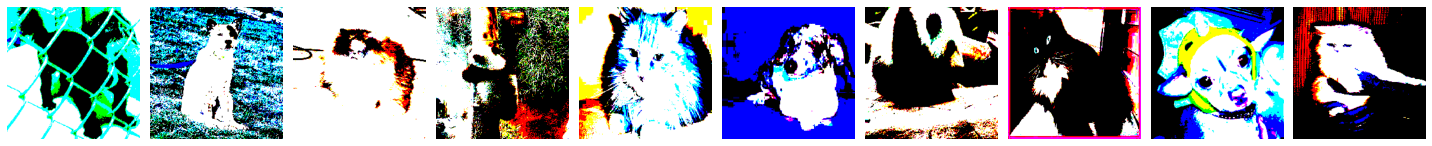

(10, 224, 224, 3)


In [68]:
plotImages(train)
print(train.shape)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

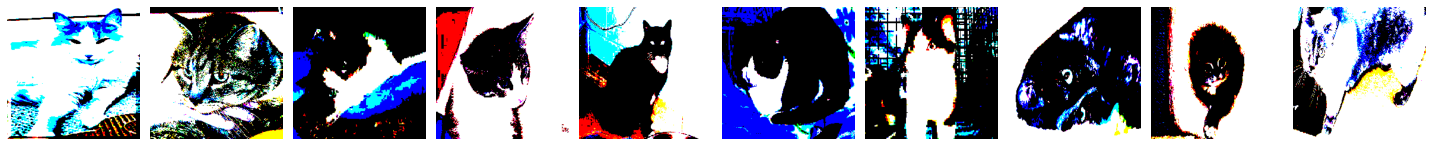

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


In [67]:
test_imgs, text_labels = next(test_batches)
plotImages(test_imgs)
print(text_labels)

## CNN sem métodos de melhora de performance

In [17]:
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
model = keras.models.Sequential([
Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same',
input_shape=(224, 224, 3)),
MaxPool2D(pool_size=(2,2), strides=2),
Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
MaxPool2D(pool_size=(2,2), strides=2),
Flatten(),
Dense(units=3, activation='softmax')])

In [18]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
history = model.fit(train_batches, epochs=20,validation_data=valid_batches)

Epoch 1/20
150/150 [==============================] - 111s 732ms/step - loss: 23.4911 - accuracy: 0.4833 - val_loss: 0.9905 - val_accuracy: 0.5067
Epoch 2/20
150/150 [==============================] - 109s 728ms/step - loss: 0.8874 - accuracy: 0.5813 - val_loss: 1.0416 - val_accuracy: 0.4833
Epoch 3/20
150/150 [==============================] - 109s 723ms/step - loss: 0.5969 - accuracy: 0.7673 - val_loss: 1.0157 - val_accuracy: 0.5267
Epoch 4/20
150/150 [==============================] - 109s 724ms/step - loss: 0.2617 - accuracy: 0.9167 - val_loss: 1.3336 - val_accuracy: 0.5367
Epoch 5/20
150/150 [==============================] - 109s 724ms/step - loss: 0.0937 - accuracy: 0.9733 - val_loss: 1.4361 - val_accuracy: 0.5367
Epoch 6/20
150/150 [==============================] - 109s 725ms/step - loss: 0.0431 - accuracy: 0.9887 - val_loss: 2.2433 - val_accuracy: 0.5133
Epoch 7/20
150/150 [==============================] - 108s 723ms/step - loss: 0.1129 - accuracy: 0.9687 - val_loss: 2.4650 

## CNN com métodos de melhora de performance

In [58]:
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import L2 


#eu utilizei esse formato de 'model.add', pois foi a única forma que encontrei para aplicar BatchNormalization
#same padding para preservar tamanhao dos feature maps 
model = keras.models.Sequential()
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', input_shape=(224, 224, 3),
                 kernel_regularizer=L2(1e-4)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('elu')) 
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=2))
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same',
                 kernel_regularizer=L2(1e-4))) 
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('elu')) 
model.add(MaxPool2D(pool_size=(2,2), strides=2))
model.add(Flatten())
model.add(keras.layers.Dense(64, kernel_regularizer=L2(1e-4)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('elu')) 
model.add(keras.layers.Dropout(0.5))
model.add(Dense(units=3, activation='softmax'))

In [31]:
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.optimizers.schedules import ExponentialDecay 


#Learning rate scheduler que não funcionou bem
#initial_learning_rate = 0.1
#lr_schedule = ExponentialDecay(
#    initial_learning_rate,
#    decay_steps=100000, decay_rate=0.96, staircase=True)


model.compile(optimizer=Nadam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [32]:
from keras.callbacks import EarlyStopping 

early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

history = model.fit(train_batches, epochs=20,validation_data=valid_batches, callbacks=[ early_stopping_cb])

Epoch 1/20
150/150 [==============================] - 192s 1s/step - loss: 1.0989 - accuracy: 0.5580 - val_loss: 1.7165 - val_accuracy: 0.4733
Epoch 2/20
150/150 [==============================] - 189s 1s/step - loss: 0.8106 - accuracy: 0.6440 - val_loss: 0.7668 - val_accuracy: 0.6100
Epoch 3/20
150/150 [==============================] - 190s 1s/step - loss: 0.7000 - accuracy: 0.6760 - val_loss: 0.7826 - val_accuracy: 0.6433
Epoch 4/20
150/150 [==============================] - 190s 1s/step - loss: 0.6132 - accuracy: 0.7260 - val_loss: 0.7136 - val_accuracy: 0.6667
Epoch 5/20
150/150 [==============================] - 193s 1s/step - loss: 0.4934 - accuracy: 0.7893 - val_loss: 0.6680 - val_accuracy: 0.6733
Epoch 6/20
150/150 [==============================] - 191s 1s/step - loss: 0.4417 - accuracy: 0.8160 - val_loss: 0.8188 - val_accuracy: 0.6233
Epoch 7/20
150/150 [==============================] - 190s 1s/step - loss: 0.3286 - accuracy: 0.8740 - val_loss: 0.7896 - val_accuracy: 0.6567

In [33]:
predictions = model.predict(x=test_batches)

In [37]:
model.save('Modelo_melhorado.h5')

## CNN via Transfer Learning de Xception 

In [70]:
base_model = keras.applications.VGG16(weights="imagenet", include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(3, activation="softmax")(avg)
model_transfer = keras.Model(inputs=base_model.input, outputs=output)

In [ ]:
for layer in base_model.layers:
  layer.trainable = False

optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
model_transfer.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = model_transfer.fit(train_batches, epochs=5, validation_data=valid_batches)

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


150/150 [==============================] - 901s 6s/step - loss: 29.2189 - accuracy: 0.9513 - val_loss: 16.7250 - val_accuracy: 0.9800
Epoch 2/5
150/150 [==============================] - 897s 6s/step - loss: 6.1704 - accuracy: 0.9860 - val_loss: 12.1642 - val_accuracy: 0.9800
Epoch 3/5
150/150 [==============================] - 897s 6s/step - loss: 2.3048 - accuracy: 0.9953 - val_loss: 8.5729 - val_accuracy: 0.9867
Epoch 4/5
150/150 [==============================] - 899s 6s/step - loss: 2.2913 - accuracy: 0.9947 - val_loss: 9.2214 - val_accuracy: 0.9833
Epoch 5/5
112/150 [=====================>........] - ETA: 3:09 - loss: 1.2861 - accuracy: 0.9946

In [36]:
for layer in base_model.layers:
  layer.trainable = True


optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=0.001)
model_transfer.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = model_transfer.fit(train_batches, epochs=5, validation_data=valid_batches)

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


150/150 [==============================] - 1284s 9s/step - loss: 2.7005 - accuracy: 0.4987 - val_loss: 177.6661 - val_accuracy: 0.5500
Epoch 2/5
150/150 [==============================] - 1271s 8s/step - loss: 1.2631 - accuracy: 0.5160 - val_loss: 5.5152 - val_accuracy: 0.5200
Epoch 3/5
150/150 [==============================] - 1305s 9s/step - loss: 0.9494 - accuracy: 0.5567 - val_loss: 0.6848 - val_accuracy: 0.5833
Epoch 4/5
150/150 [==============================] - 1262s 8s/step - loss: 0.7721 - accuracy: 0.5807 - val_loss: 0.9340 - val_accuracy: 0.4667
Epoch 5/5
150/150 [==============================] - 1252s 8s/step - loss: 0.7653 - accuracy: 0.5847 - val_loss: 0.6785 - val_accuracy: 0.5967


In [40]:
predictions_transfer = model.predict(x=test_batches)

In [42]:
model_transfer.save('Modelo_transfer_learning.h5')

## Fazendo matriz de confusão dos resultados e predições do modelo próprio


In [ ]:
test_batches.class_indices

              precision    recall  f1-score   support

           0       0.59      0.76      0.67        50
           1       0.57      0.56      0.57        50
           2       1.00      0.74      0.85        50

    accuracy                           0.69       150
   macro avg       0.72      0.69      0.69       150
weighted avg       0.72      0.69      0.69       150



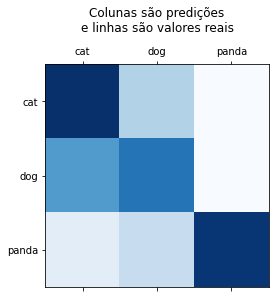

In [34]:
from sklearn.metrics import confusion_matrix, classification_report
quant = [0, 1 ,2]
cm_plot_labels = ['cat', 'dog', 'panda']
print(classification_report(y_true = test_batches.classes, y_pred = np.argmax(predictions, axis=-1)))

conf_mx = confusion_matrix(y_true=test_batches.classes, y_pred= np.argmax(predictions, axis=-1))
plt.matshow(conf_mx, cmap= plt.cm.Blues) 
plt.xticks(quant, cm_plot_labels)
plt.yticks(quant, cm_plot_labels)
plt.title('Colunas são predições\ne linhas são valores reais\n')
plt.show()

## Fazendo matriz de confusão dos resultados e predições do modelo adaptado de transfer learning 

              precision    recall  f1-score   support

           0       0.59      0.76      0.67        50
           1       0.57      0.56      0.57        50
           2       1.00      0.74      0.85        50

    accuracy                           0.69       150
   macro avg       0.72      0.69      0.69       150
weighted avg       0.72      0.69      0.69       150



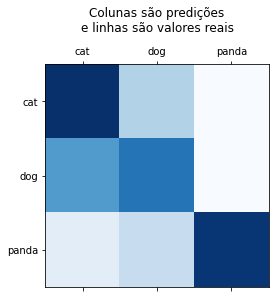

In [43]:
from sklearn.metrics import confusion_matrix, classification_report
quant = [0, 1 ,2]
cm_plot_labels = ['cat', 'dog', 'panda']
print(classification_report(test_batches.classes, np.argmax(predictions_transfer, axis=-1)))

conf_mx = confusion_matrix(y_true=test_batches.classes, y_pred= np.argmax(predictions_transfer, axis=-1))
plt.matshow(conf_mx, cmap= plt.cm.Blues) 
plt.xticks(quant, cm_plot_labels)
plt.yticks(quant, cm_plot_labels)
plt.title('Colunas são predições\ne linhas são valores reais\n')
plt.show()